In [234]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import Adam
from keras.preprocessing import image
import gym
import numpy as np
from collections import deque
import random
import sys
import pandas as pd


In [257]:
env = gym.make('Breakout-v0')
env.observation_space, env.action_space

(Box(210, 160, 3), Discrete(4))

In [275]:
class DQN:
    
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2000)
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon= 1
        self.eps_decay_rate = 0.9995
        self.gamma = 0.70
        self.lr = 0.01
        self.min_eps = 0.01
        self.model = self._build_model()
    
    def preprocess(self, image):
        img = Image.fromarray(image)
        state =  np.expand_dims(np.asarray(np.max(img.resize((84,84)), axis=2)),axis=2)
        ns = np.expand_dims(state,axis=0)
        #print("State DIMS: ",state.shape, " NS DIMES: ",ns.shape)
        return ns
        
    
    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, 8 , strides=(2, 2), padding='valid', activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, 4 , strides=(4, 4), padding='valid', activation='relu'))
        model.add(Conv2D(128, 3 ,strides=(2, 2), padding='valid', activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr), metrics=['accuracy'])
        return model
    
    def mem_size(self):
        return len(self.memory)
    
    def check_shape(self, state):
        return True if state.shape[2] > self.state_size[2] else False
        
    def act(self, state):
        #print("STATE SIZE: ", state.shape)
        if self.check_shape(state):
            state = self.preprocess(state)
        #print("STATE AFTER ",state.shape)
        prob = np.random.rand()
        if prob < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            action = np.argmax(self.model.predict(state)[0])
        return action
            
    def remember(self, state, action, reward, next_state, done):
        if self.check_shape(state) or self.check_shape(next_state):
            state = self.preprocess(state)
            next_state = self.preprocess(next_state)
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f =self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.min_eps:
            self.epsilon *= self.eps_decay_rate
            
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

        

In [276]:
len(env.observation_space.shape[:2])

2

In [277]:
# Initialize state_size, action_size
state_size = (84,84,1)
action_size = env.action_space.n

# Create an Agent with required State and Action sizes
agent = DQN(state_size, action_size)

In [278]:
def train(env, n_episodes=100, batch_size=32):
    
    avg_reward = []
    max_avg = -np.inf
    for i_ep in range(n_episodes):
        
        state = env.reset()
        total_reward = 0
        for t in range(600):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            #env.render()
            agent.remember(state, action, reward, next_state, done)
            if done:
                break
        avg_reward.append(total_reward)
        avg = np.mean(avg_reward[-100:])
        if (max_avg < avg):
            max_avg = avg
        print("\repisode: {}/{},Max: {:.2f} score: {:.2f}".format(i_ep+1, n_episodes, max_avg, avg),end="")
        sys.stdout.flush()
        
        if agent.mem_size() >= batch_size:
            agent.replay(batch_size)
    return avg_reward

In [279]:
scores = train(env, n_episodes=100)

episode: 100/100,Max: 1.67 score: 1.36

In [265]:
def test(env, n_episodes=10, batch_size=32):
    
    avg_reward = []
    max_avg = -np.inf
    for i_ep in range(n_episodes):
        
        state = env.reset()
        total_reward = 0
        done = False
        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            env.render()
            total_reward += reward
            agent.remember(state, action, reward, next_state, done)
            if done:
                break
        env.close()
        avg_reward.append(total_reward)
        avg = np.mean(avg_reward)
        if (max_avg < avg):
            max_avg = avg
        print("\repisode: {}/{},Max: {:.2f} score: {:.2f}".format(i_ep+1, n_episodes, max_avg, avg),end="")
        sys.stdout.flush()
        
    return avg_reward

In [274]:
scores_test = test(env)

episode: 10/10,Max: 1.12 score: 0.90

In [219]:
state = env.reset()

done = False
while True:
    next_state, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    if done:
        break
env.close()
        

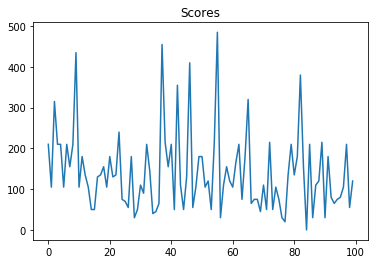

In [239]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores_test)

In [250]:
env.close()